Evaluate Graph models 

In [37]:
import os
import re
import networkx as nx
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from fuzzywuzzy import process
from absl import logging


In [63]:
dataset = "HDFS"
# G = nx.read_gpickle('models/'+dataset+'_Bigram.gpickle')
G = nx.read_gpickle("models/" + dataset + "sim.gpickle")
#



In [64]:
for node in sorted(G.nodes()):
    print(node)
len(G.nodes())


BLOCK Name System add Stored Block block Map updated added <*> size <*>
BLOCK Name System allocate Block user root <*> rand temporary task <*> part <*>
BLOCK Name System allocate Block user root <*> temporary task <*> part <*>
BLOCK Name System allocate Block user root rand <*> temporary task <*> part <*>
BLOCK Name System allocate Block user root rand t<*> emporary task <*> part <*>
BLOCK Name System delete <*> added invalid Set
BLOCK ask delete <*>
BLOCK ask replicate <*> data node
Deleting block <*> file had oop data current <*>
Got exception while serving <*>
Packet Responder <*> for block <*> terminating
Received block <*> size <*><*>
Receiving block <*>
Served block <*>
Starting thread transfer block <*>
Verification succeeded for <*>


16

Comparing one to one values from our templates to swisslog using  Levenshtein Distance 

In [65]:
def compare_templates(path):
    df = pd.read_csv(path)
    df.pop(df.columns[0])
    your_list = df.EventTemplate.to_list()
    sim_dict = {}
    results, sim_list = [], []
    for element in G.nodes():
        a = process.extractOne(element, your_list)  ##COMPARING LINE BY LINE
        sim_dict[element] = a
        results.append(list(a)[1])
        sim_list.append(element)
        sim_list.append(list(a)[0])
    print(" The average similarity between both document is ", np.average(results))
    return sim_list


sim_list = compare_templates(
    "logs/" + dataset + "/" + dataset + "_2k.log_templates.csv"
)



 The average similarity between both document is  90.5


In [66]:
sim_list


['BLOCK Name System allocate Block user root rand <*> temporary task <*> part <*>',
 '<*>Adding an already existing block<*>',
 'Receiving block <*>',
 '<*>Receiving block<*>src:<*>dest:<*>',
 'Received block <*> size <*><*>',
 '<*>Received block<*>of size<*>from<*>',
 'Packet Responder <*> for block <*> terminating',
 '<*>PacketResponder <*> for block <*> terminating<*>',
 'BLOCK Name System add Stored Block block Map updated added <*> size <*>',
 '<*>BLOCK* NameSystem<*>addStoredBlock: blockMap updated:<*>is added to<*>size<*>',
 'Deleting block <*> file had oop data current <*>',
 '<*>Served block<*>to<*>',
 'BLOCK Name System allocate Block user root <*> temporary task <*> part <*>',
 '<*>Adding an already existing block<*>',
 'Served block <*>',
 '<*>Served block<*>to<*>',
 'BLOCK ask delete <*>',
 '<*>Adding an already existing block<*>',
 'Starting thread transfer block <*>',
 '<*>Starting thread to transfer block<*>to<*>',
 'Got exception while serving <*>',
 '<*>Got exception 

Now we compare semantic similariy visualizing in a heatmap the first 10 templates using sentence encoder model from google

In [67]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"  # @param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print("module %s loaded" % module_url)


def embed(input):
    return model(input)



module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


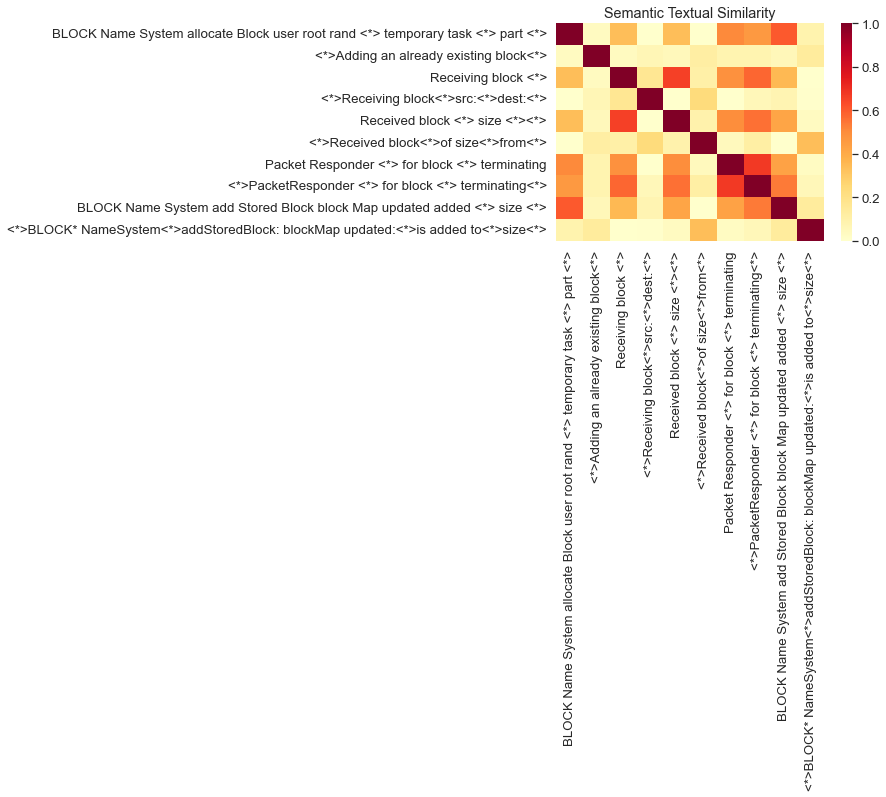

In [68]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd"
    )
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")


def run_and_plot(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_[0:10], message_embeddings_[0:10], 90)


run_and_plot(sim_list)


Betweenes centrality  to measure  to identify nodes that play a central role in the communication structure of a graph. From this we gathered the nodes in the case of the bigrams graph the most frequents and for the semantic similarity graph we understand the  actions that are most done in the systems gaining more insights in the system

In [70]:
# get words corresponding to nodes (in scoring order)
node_scores = nx.betweenness_centrality(G)
sorted_node_scores = dict(sorted(node_scores.items(), key=lambda item: -item[1]))
sorted_nodes = list(sorted_node_scores.keys())

# candidate KW = highest scoring nodes (1/3 of all nodes)
candidate_kw = sorted_nodes[: int(len(sorted_nodes) / 3)]
candidate_kw


['Packet Responder <*> for block <*> terminating',
 'Receiving block <*>',
 'Received block <*> size <*><*>',
 'Starting thread transfer block <*>',
 'BLOCK Name System add Stored Block block Map updated added <*> size <*>']

In [72]:
[n for n in G.neighbors(candidate_kw[0])]


['BLOCK Name System allocate Block user root rand <*> temporary task <*> part <*>',
 'Receiving block <*>',
 'Starting thread transfer block <*>',
 'BLOCK Name System allocate Block user root <*> rand temporary task <*> part <*>',
 'Verification succeeded for <*>']

function return  The Jaccard coefficient  used to identify similar vertices in the graph, community detection and link prediction. 

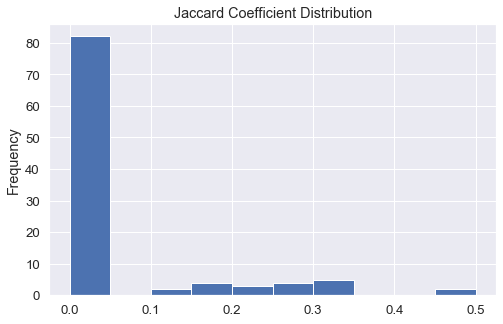

In [73]:
def get_jaccard_coefficients(graph):
    return pd.DataFrame(
        sorted(list(nx.jaccard_coefficient(graph)), key=lambda x: x[-1], reverse=True),
        columns=["source", "target", "jaccard_coefficient"],
    )


jaccard_coefficients_df = get_jaccard_coefficients(G)
try:
    jaccard_coefficients_df.jaccard_coefficient.plot.hist(
        bins=10, figsize=(8, 5), title="Jaccard Coefficient Distribution"
    )
except:
    print("Strongly connected graph")


Link predicion : We get common neigbors betweeen two nodes and visualize it
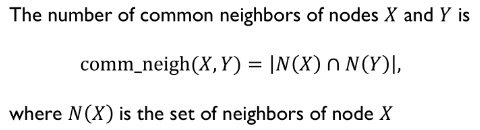

In [74]:
# function to return the subgraph containing 2 nodes' common neighbors
def get_common_neighbor_subgraph(graph, source, target):
    nodes = [source, target] + list(nx.common_neighbors(G, source, target))
    return graph.subgraph(nodes)


# function create node color list for likely connected two nodes with their
# common neighbors
def create_source_target_colors(graph, source, target):
    nodes = list(graph.nodes())
    potential_connected_node_colors = ["#EFD1BB"] * len(nodes)
    for index in range(len(nodes)):
        if nodes[index] in [source, target]:
            potential_connected_node_colors[index] = "#F47315"
    return potential_connected_node_colors


def visualize_likely_connected_nodes(graph, source, target):
    # get subgraph
    subgraph = get_common_neighbor_subgraph(G, source, target)

    # create visualization
    node_colors = create_source_target_colors(subgraph, source, target)
    title = dataset + f" Graph {source} and {target}"
    pos = nx.spring_layout(subgraph, k=0.3, iterations=50, seed=2)

    plt.figure(1, figsize=(10, 6))
    nx.draw(
        subgraph,
        pos=pos,
        node_size=1000,
        node_color=node_colors,
        with_labels=True,
        font_size=20,
        font_color="black",
    )
    plt.title(title)
    plt.show()


In [75]:
# function to return a node's neighbor nodes as a list
def get_neighbors(graph, node):
    return [n for n in graph.neighbors(node)]


get_neighbors(G, candidate_kw[1])


['Received block <*> size <*><*>',
 'Packet Responder <*> for block <*> terminating',
 'Served block <*>',
 'Starting thread transfer block <*>']

In [76]:
jaccard_coefficients_df.head(10)



,source,target,jaccard_coefficient
0,BLOCK Name System delete <*> added invalid Set,Received block <*> size <*><*>,0.500000
1,Received block <*> size <*><*>,Served block <*>,0.500000
2,BLOCK Name System allocate Block user root <*>...,Packet Responder <*> for block <*> terminating,0.333333
3,Starting thread transfer block <*>,Verification succeeded for <*>,0.333333
4,Starting thread transfer block <*>,Served block <*>,0.333333
5,Starting thread transfer block <*>,BLOCK ask replicate <*> data node,0.333333
6,BLOCK Name System allocate Block user root ran...,Packet Responder <*> for block <*> terminating,0.333333
7,BLOCK Name System allocate Block user root ran...,Verification succeeded for <*>,0.250000
8,Starting thread transfer block <*>,Received block <*> size <*><*>,0.250000
9,BLOCK Name System allocate Block user root <*>...,Verification succeeded for <*>,0.250000


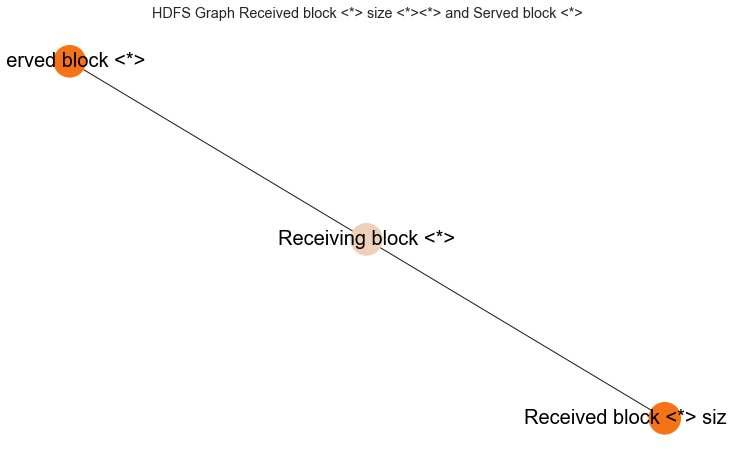

In [77]:
visualize_likely_connected_nodes(
    G, jaccard_coefficients_df.source[1], jaccard_coefficients_df.target[1]
)



resource allocation index for link predicrion,  One observation is that two potentially connected nodes with many connections will have resource allocation index greater than 1 when their neighbors have less common neighbors. In this way, the percentage of resources allocated will be higher per common neighbor nodes.

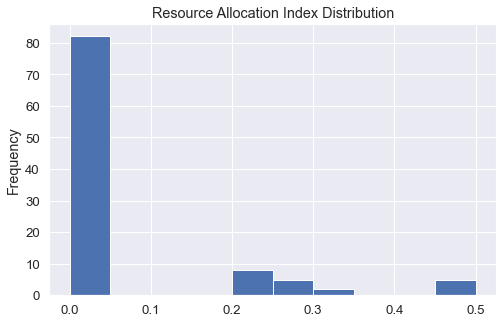

In [78]:
# function return the resource allocation index dataframe sorted by the
# resource allocation index value
def get_resource_allocation_index(graph):
    return pd.DataFrame(
        sorted(
            list(nx.resource_allocation_index(graph)), key=lambda x: x[-1], reverse=True
        ),
        columns=["source", "target", "resource_allocation_index"],
    )


resource_allocation_index_df = get_resource_allocation_index(G)
if len(resource_allocation_index_df) > 1:
    resource_allocation_index_df.resource_allocation_index.plot.hist(
        bins=10, figsize=(8, 5), title="Resource Allocation Index Distribution"
    )
else:
    print("Strongly connected graph")


In [79]:
resource_allocation_index_df.head()
resource_allocation_index_df.to_clipboard()


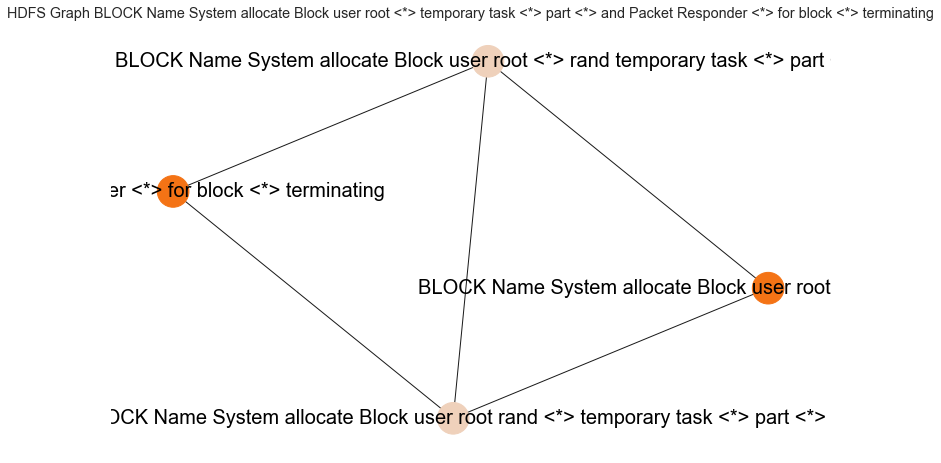

In [80]:
visualize_likely_connected_nodes(
    G, resource_allocation_index_df.source[0], resource_allocation_index_df.target[0]
)



In [81]:
def get_graph_info(graph):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    print("Average Cluster Coefficients:", nx.average_clustering(graph))
    print("Connected components:", len(list(nx.connected_components(graph))))


get_graph_info(G)


Number of nodes: 16
Number of edges: 18
Average Cluster Coefficients: 0.2520833333333333
Connected components: 3


In [82]:
import networkx.algorithms.community as nx_comm

# function create node color list for less than 7 communities
# when there are more than 6 colors, visualization can be confusing for human
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = [
        "#EF9A9A",
        "#BA68C8",
        "#64B5F6",
        "#81C784",
        "#FFF176",
        "#BDBDBD",
    ] * number_of_colors
    node_colors = []

    # iterate each node in the graph and find which community it belongs to
    # if the current node is found at a specific community, add color to the
    # node_colors list
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors


def visualize_communities(graph, communities):
    # create visualization
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx_comm.modularity(graph, communities), 11)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)

    plt.figure(1, figsize=(10, 6))
    nx.draw(
        graph,
        pos=pos,
        node_size=1000,
        node_color=node_colors,
        with_labels=False,
        font_size=20,
        font_color="black",
    )
    plt.title(title)
    plt.show()


In [85]:
from networkx.algorithms.community import greedy_modularity_communities

c = greedy_modularity_communities(G)
c[0]


frozenset({'BLOCK Name System add Stored Block block Map updated added <*> size <*>',
           'BLOCK Name System delete <*> added invalid Set',
           'Received block <*> size <*><*>',
           'Receiving block <*>',
           'Served block <*>'})

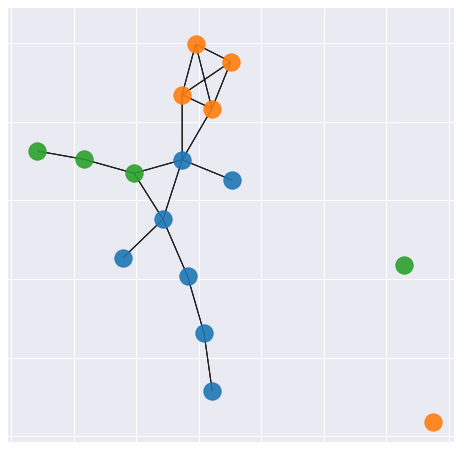

In [86]:
# list of detected communities
c = list(greedy_modularity_communities(G))
sortedCommunities = []

# iterate through list of discovered communities. Sort each community and add them to new list.

for community in c:
    sortedCommunities.append(sorted(community))

# draw community
# here we are using a different color at each iteration but cycling back to the first color.

community_to_color = {
    0: "tab:blue",
    1: "tab:orange",
    2: "tab:green",
    3: "tab:red",
}
temp_counter = 0
pos = nx.nx_agraph.graphviz_layout(G)
# color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
# pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(8, 8))
for community in sortedCommunities:

    chosenColor = community_to_color[temp_counter % 3]
    temp_counter += 1
    nx.draw_networkx_nodes(
        G, pos, nodelist=community, label=True, node_color=chosenColor, alpha=0.9
    )
    nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()


In [87]:
sortedCommunities


[['BLOCK Name System add Stored Block block Map updated added <*> size <*>',
  'BLOCK Name System delete <*> added invalid Set',
  'Received block <*> size <*><*>',
  'Receiving block <*>',
  'Served block <*>'],
 ['BLOCK Name System allocate Block user root <*> rand temporary task <*> part <*>',
  'BLOCK Name System allocate Block user root <*> temporary task <*> part <*>',
  'BLOCK Name System allocate Block user root rand <*> temporary task <*> part <*>',
  'BLOCK Name System allocate Block user root rand t<*> emporary task <*> part <*>'],
 ['BLOCK ask replicate <*> data node',
  'Deleting block <*> file had oop data current <*>',
  'Starting thread transfer block <*>'],
 ['Packet Responder <*> for block <*> terminating',
  'Verification succeeded for <*>'],
 ['BLOCK ask delete <*>'],
 ['Got exception while serving <*>']]